# Portfolio constraints

* Python has the flexibility to solve the mean-variance problem numerically

* Allows you to impose realistic features to our portfolio problem 

  * Shorting costs
  * Borrowing costs higher than lending costs
  * Leverage constraints
  * Position limits due to investment mandates


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#GlobalFinMonthly
url="https://www.dropbox.com/s/3k35mt3t57ygff2/GlobalFinMonthly.csv?dl=1"
Data = pd.read_csv(url,na_values=-99)
# tell python Date is date:
Data['Date']=pd.to_datetime(Data['Date'])
# set an an index
Data=Data.set_index(['Date'])
Data=Data.rename(columns={Data.columns[1]: "MKTUS",Data.columns[2]: "BondUS",
                          Data.columns[3]: "EM",Data.columns[4]: "MKTxUS",Data.columns[5]: "BondxUS" })
Re=(Data.drop('RF',axis=1)).subtract(Data['RF'],axis='index')
Re.tail()

,MKTUS,BondUS,EM,MKTxUS,BondxUS
Date,,,,,
2016-08-31,0.0050,-0.008617,0.024986,0.000638,-0.009752
2016-09-30,0.0025,-0.016617,0.012953,0.012536,0.009779
2016-10-31,-0.0202,-0.049660,0.002274,-0.020583,-0.043676
2016-11-30,0.0486,-0.081736,-0.046071,-0.019898,-0.050459
2016-12-31,0.0182,-0.005596,0.002604,0.034083,-0.023507


In [2]:
# start by importing optimization package -- think of a much more powerful solver (excel)

from scipy.optimize import minimize

* we will now learn how to do a numerical minimization. 

* start by defining some useful variables

In [3]:
# excess returns
Re=Data.subtract(Data['RF'],axis='index').drop('RF',axis=1)

Re.tail()

,MKTUS,BondUS,EM,MKTxUS,BondxUS
Date,,,,,
2016-08-31,0.0050,-0.008617,0.024986,0.000638,-0.009752
2016-09-30,0.0025,-0.016617,0.012953,0.012536,0.009779
2016-10-31,-0.0202,-0.049660,0.002274,-0.020583,-0.043676
2016-11-30,0.0486,-0.081736,-0.046071,-0.019898,-0.050459
2016-12-31,0.0182,-0.005596,0.002604,0.034083,-0.023507


In [4]:
ERe=Re.mean()
print(ERe)
Cove=Re.cov()
print(Cove)

MKTUS      0.005140
BondUS     0.002523
EM         0.006923
MKTxUS     0.004149
BondxUS    0.002054
dtype: float64
            MKTUS    BondUS        EM    MKTxUS   BondxUS
MKTUS    0.001948  0.000111  0.001292  0.001264  0.000187
BondUS   0.000111  0.001227 -0.000204 -0.000013  0.000264
EM       0.001292 -0.000204  0.003556  0.001661  0.000249
MKTxUS   0.001264 -0.000013  0.001661  0.002182  0.000422
BondxUS  0.000187  0.000264  0.000249  0.000422  0.000407


In [5]:
# the risk-free rate is special because at a given time we know exactly what the expected returns of investing
# in it, since it is risk-free!
# so it does not make sense to use the average risk-free rate in the portfolio problem, and we should rather use the one that
# we currently can invest at no risk
# here we are dividing by 12 becasue we are using annualized numbers
rf=0.0192/12
print(rf)

# below is the target for monthly expected returns
Ertarget=0.06/12
print(Ertarget)

# below is maximum amount of borrowing at the risk-free rate. 1.5 means that for each dollar you put in you can borrow 
# up to 50 cents and have a total risk asset portfolio of 1.5 dollars
levlimit=1

0.0015999999999999999
0.005


* The program will choose a vector of weights that minimzies some function (of the chosen weights) subject to some constraint

* we need to provide an initial condition for these weights, which essentially tells python the shape of the variable that it is choosing. Here we will start with a equal weighted portfolio

* When solving minimization problems it is important to check that the exact initial conditions that you put in don't matter. 

* I mean, it's shape obviously matter, but whether is equal weighted or any other weighting scheme, the minimization should end up in the same place otherwise the numerical is not converging and you need to adjust the stop conditions

* We refer to this as making sure that you are finding a "global optimum" and not a "local optimum"

In [6]:
n=Re.shape[1]
W0=np.ones(n)/n 
W0


array([0.2, 0.2, 0.2, 0.2, 0.2])

* We need to specify the function that our minimizer will try to minimize,i.e, our objective

* obviously this should be written as a function of the portfolio weights

* In this case it is the variance of a portfolio with weights W

* the weights will be our choice variable

* The minimization function will change the weights until this variance is minimized



In [7]:
# STEP 1: define the objective function, which is the variance of the portfolio in our case

def func(W,Cove=Re.cov()):
    return W.T @ Cove @ W


* Finally we need to specify the set of constraints that the minimization problem must satisfy

* you can specify two types of constraints: Equalities and inequalities.

* Equalities:
   * specified as 'eq' 
   * For example:`{'eq', 'fun' : lambda W : W.T @ ERe.values+rf-target}`
     * defines the function `F(W)=W.T @ ERe.values+rf-target`
     * and requires W to satisfy F(W)=0, i.e., `W.T @ ERe.values+rf=target`, or
     $$W' E[R^e]+R^f=target$$
     * "target" here is the target for expected returns
     
* Inequalities:
   * specified as 'ineq'
   * For example: `{'ineq', 'fun' : lambda W: -W.sum()+levlimit}`
   * Defines  `F(W)=-W.sum()+levlimit`
   * and requires F(W)>=0, i.e.,
   
   $$levlimit\geq W.sum()$$

In [8]:
ERe*12

MKTUS      0.061684
BondUS     0.030272
EM         0.083079
MKTxUS     0.049788
BondxUS    0.024650
dtype: float64

In [9]:
Re.corr()

,MKTUS,BondUS,EM,MKTxUS,BondxUS
MKTUS,1.000000,0.071609,0.491055,0.613081,0.210263
BondUS,0.071609,1.000000,-0.097846,-0.007781,0.373399
EM,0.491055,-0.097846,1.000000,0.596177,0.207206
MKTxUS,0.613081,-0.007781,0.596177,1.000000,0.447951
BondxUS,0.210263,0.373399,0.207206,0.447951,1.000000


In [10]:
# STEP 2: define constraint functions, we have two constraints: (1) target average return, and (2) leverage limit
Ertarget=0.12/12
cons=({'type': 'eq',
          'fun' : lambda W : W.T @ ERe.values+rf-Ertarget},
        {'type': 'ineq',
          'fun' : lambda W: -W.sum()+levlimit}) 


cons


({'type': 'eq', 'fun': <function __main__.<lambda>(W)>},
 {'type': 'ineq', 'fun': <function __main__.<lambda>(W)>})

* Finally we are ready to do our minimization
* `options={'disp': True}`: tell python to report intermediary steps so we can check if the algorithm is doing progress towards a solution.
* There is a variety of additional parameters that you can pass to the minimizer. 
* see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html


In [11]:
# STEP 3: solve the minimization problem with constraints and save as `sol`

sol = minimize(lambda x: func(x,Cove=Re.cov()),W0, constraints=cons, options={'disp': True})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0044263793644412665
            Iterations: 7
            Function evaluations: 42
            Gradient evaluations: 7


In [12]:
sol.x.sum()

0.999999998431648

In [13]:
#skip
# Retemp=Re.iloc[:,0:4].copy()
# n=Retemp.shape[1]
# W0=np.ones(n)/n 
# W0

# def func(W,Cove=Re.cov()):
#     return W.T @ Cove @ W

# cons=({'type': 'eq',
#           'fun' : lambda W : W.T @ Retemp.mean().values+rf-Ertarget},
#         {'type': 'ineq',
#           'fun' : lambda W: -W.sum()+levlimit}) 
# sol = minimize(lambda x: func(x,Cove=Retemp.cov()),W0, constraints=cons, options={'disp': True})
# sol.x

In [14]:
# STEP 4: get the optimal portfolio weights

sol.x

array([ 0.76797288,  0.42185164,  0.96139604, -0.431085  , -0.72013556])

* Solution is saved in sol
* Lets plot the optimal weights

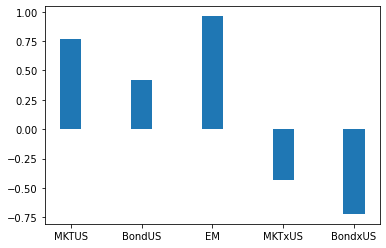

In [15]:

# below I am plotting the solution weights.
width=0.3
ind=np.arange(Re.shape[1])
fig, ax = plt.subplots()
ax.bar(ind,sol.x,width)

# ax.set_xticks(np.array([0,1,2,3,4,5])+ width / 2)
ax.set_xticks(ind)
ax.set_xticklabels(Re.columns)
plt.show()

* We can now use a for loop to trace out the entire mean-variance frontier when neither borrowing or lending at the risk-free rate is allowed

* we do this by minimizing the variance with different targets for expected returns

In [ ]:
def expected_return(W):
     return W.T @ ERe.values+((W[W<0]*fee).sum()+rf

In [71]:
# here we constructing a list of target ranging from the risk-free rate until 12%, 
# with 40 equally distanced points in between
levlimit=40
mutargets=np.linspace(rf,0.50/12,20)
spread=0.02/12
# We are initiating a list where we will be storing the results
minstd=[]

# we now simply loop over the different expected return targets in the vector which we just constructed

fee=0.05/12

for a0 in mutargets:
    #   1. The loop fisrt define the new constraint with the new expected return target given by a0
    cons=({'type': 'eq',
          'fun' : lambda W : W.T @ ERe.values+(-W[W<0]*fee).sum()+rf-np.abs((W.sum()-1))*spread-a0},
        {'type': 'ineq',
          'fun' : lambda W: -W.sum()+1+levlimit} ,
        {'type': 'ineq',
          'fun' : lambda W: W[[0,1]]})
    #   2. It then performs the minimization
    res1 = minimize(func,W0,  constraints=cons, options={'disp': False},tol=0.00000000000001)
#    print(res1.x)
    #   3. Finally it appends the solution to the list that we just created. 
    #        Here we are saving the square root of the objective function, which is simply the standard deviaiton 
    #        of the optimal portfolio. And the also the expected return obtained (alternatively we could have simply saved a0)
    minstd.append([res1.fun**0.5,res1.x.T @ ERe.values+(-res1.x[res1.x<0]*fee).sum()+rf-np.abs((res1.x.sum()-1))*spread,res1.x.sum(),res1.x.min()])

* We can now plot the mean-standard-deviation frontiers by plotting the obtained standard deviation in the x-axis and the obtained expected returns in the y-axis


### Side note

In [41]:
levlimit=0
rf=0
mutargets=np.linspace(rf,0.50/12,20)
minstd=[]
a0=0.5/12
cons=({'type': 'eq',
      'fun' : lambda W : W.T @ ERe.values+rf-a0},
    {'type': 'ineq',
      'fun' : lambda W: -(W).sum()+1+levlimit},
        {'type': 'ineq',
          'fun' : lambda W: W} )

res1 = minimize(func,W0,  constraints=cons, options={'disp': False},tol=0.00000000000001)
prnt([(res1.fun*12)**0.5,12*(res1.x.T @ ERe.values+rf),res1.x.sum(),res1.x.min()])
print(res1.x)
print(res1.x.sum())

[0.2065811327215539,
 0.08307943849270083,
 1.0000000000010738,
 -9.326593771415994e-12]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018565D4B7C0>,
      dtype=object)

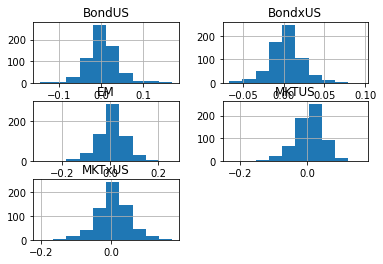

In [52]:
Re.hist()

<ipython-input-56-129b3aac83d8>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  ax=Re.hist(ax=ax)


Text(0, 0.5, 'middleright')

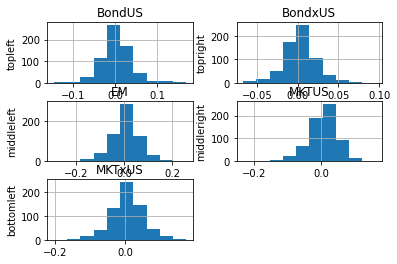

In [56]:
fig, ax = plt.subplots()
ax=Re.hist(ax=ax)
ax[0,0].set_ylabel('topleft')
ax[0,1].set_ylabel('topright')
ax[2,1].set_ylabel('bottomleft')
ax[2,0].set_ylabel('bottomleft')
ax[1,0].set_ylabel('middleleft')
ax[1,1].set_ylabel('middleright')

### End of side note

In [ ]:
 W.T @ ERe.values+rf-a0
    
 W.T @ ERe.values+(-W[W<0]*fee).sum()+rf-np.abs((W.sum()-1))*spread-a0    

In [47]:
minstd

[[3.591478745103494e-10,
  0.001600000036585007,
  1.781025499303368e-08,
  -1.6653345369377348e-16],
 [0.004207416985664804,
  0.0020421052943131253,
  0.19129790813922426,
  -1.1102230246251565e-16],
 [0.006901028123669531, 0.002484210553424129, 0.31716245547822475, 0.0],
 [0.009590358998671557,
  0.0029263158127647098,
  0.4239283981016745,
  0.008171011448185855],
 [0.01215583166575831,
  0.003368421072285655,
  0.5139028150695928,
  0.03813422380414419],
 [0.014942762248227114,
  0.0038105263318065994,
  0.603877232037511,
  0.06809743616010255],
 [0.01784770814658756,
  0.004252631591327546,
  0.6938516490054296,
  0.09806064851606093],
 [0.02082133211210155,
  0.00469473685084849,
  0.7838260659733478,
  0.12802386087201925],
 [0.02383794660026387,
  0.005136842110369436,
  0.8738004829412662,
  0.15798707322797761],
 [0.02688308329915989,
  0.00557894736989038,
  0.9637748999091845,
  0.18795028558393595],
 [0.029948043000838035,
  0.006021052629411326,
  1.053749316877103,
  0

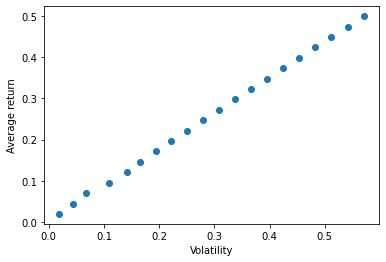

In [72]:
plt.scatter(np.array(minstd)[:,0]*12**0.5,np.array(minstd)[:,1]*12)
plt.xlabel('Volatility')
plt.ylabel('Average return')
plt.show()

* You can do a multitude of different problems by making small changes to this code:

    * Borrowing at the risk-free rate is not allowed,  but lending is allowed
    * Shorting of any asset is not allowed
    * Shorting of some assets are not allowed
    * Shorting has an extra cost
    * Leverage is allowed, but borrowing rate is higher than risk-free rate

 > How would you implement no shorting of any asset?
 
 > How would you implement no shorting of bonds, but allow investor to short equity markets (which can be done using futures)?